In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4084, done.
remote: Counting objects: 100% (4084/4084), done.
remote: Compressing objects: 100% (3077/3077), done.
remote: Total 4084 (delta 1185), reused 1981 (delta 947), pack-reused 0
Receiving objects: 100% (4084/4084), 44.62 MiB | 14.92 MiB/s, done.
Resolving deltas: 100% (1185/1185), done.
Updating files: 100% (3696/3696), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 65.4 MB/s eta 0:00:00
     ━━━━━━

In [ ]:
!pip install tensorflow=="2.15.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.5)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

def show_image_with_bboxes_from_array(image_array, bounding_boxes, iw, ih):
    fig, ax = plt.subplots(1)
    ax.imshow(image_array)

    for bbox in bounding_boxes:
        x = bbox[0] * iw
        y = bbox[1] * ih
        w = bbox[2] * iw
        h = bbox[3] * ih
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Utilities

In [ ]:
import os
import json
import cv2
from pycocotools.coco import COCO

def normalize_bbox(image_width, image_height, bbox):
    img_w = float(image_width)
    img_h = float(image_height)
    x, y, w, h = bbox
    normalized_x = x / img_w
    normalized_y = y / img_h
    normalized_w = w / img_w
    normalized_h = h / img_h
    return normalized_x, normalized_y, normalized_w, normalized_h

def convert_bbox(bbox):
  return [bbox[1],bbox[0], bbox[1] + bbox[3],bbox[0] + bbox[2]]

def extract_wheels_data(path_annotations, path_images):
    coco = COCO(path_annotations)
    categories = coco.loadCats(coco.getCatIds())
    image_ids = coco.getImgIds()
    images_infos = coco.loadImgs(image_ids)
    annotations = coco.loadAnns(coco.getAnnIds())
    images = []
    bounding_boxes = []
    for img in images_infos:
      image = load_image_into_numpy_array(f"{path_images}/{img['file_name']}")
      bbs = [convert_bbox(normalize_bbox(image.shape[1], image.shape[0], i['bbox'])) for i in annotations if i.get('image_id') == img['id']]
      if(len(bbs) == 0):
        image_ids.remove(img['id'])
        continue

      images.append(image)
      bounding_boxes.append(np.array(bbs))

    return image_ids, images, bounding_boxes

In [ ]:
ids1, images1, bounding_boxes1 = extract_wheels_data(path_annotations = "/content/drive/My Drive/IACV/Tuning/SecondFineTuning/bb1.json", path_images = '/content/drive/My Drive/IACV/Tuning/SecondFineTuning/Data')
ids2, images2, bounding_boxes2 = extract_wheels_data(path_annotations = "/content/drive/My Drive/IACV/Tuning/SecondFineTuning/bb2.json", path_images = '/content/drive/My Drive/IACV/Tuning/SecondFineTuning/imgs 2')

loading annotations into memory...
Done (t=1.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [ ]:
print(len(images1), len(images2))
print(len(bounding_boxes1), len(bounding_boxes2))

227 164
227 164


In [ ]:
ids = np.concatenate((ids1, ids2))
images = np.concatenate((images1, images2))
bounding_boxes = bounding_boxes1 + bounding_boxes2

In [ ]:
print(len(ids), len(images), len(bounding_boxes))
print(bounding_boxes[0])
s = []
for k, i in enumerate(bounding_boxes):
  s.append(i.shape)
  if(i.shape == (0,)):
    print(k)

print(set(s))

391 391 391
[[0.52281944 0.38034375 0.60140278 0.42653125]
 [0.52326389 0.20242969 0.602375   0.24938281]]
{(4, 4), (2, 4), (3, 4), (5, 4), (6, 4), (1, 4)}


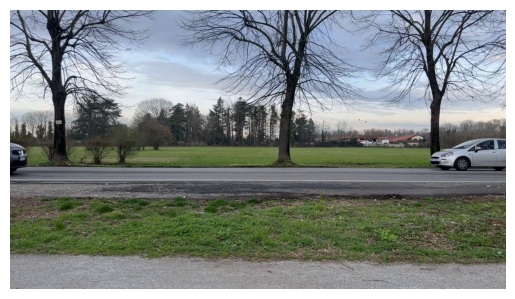

In [ ]:
plt.imshow(images[23])
plt.axis('off')
plt.show()

In [ ]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
wheel_class_id = 1
num_classes = 1

category_index = {wheel_class_id: {'id': wheel_class_id, 'name': 'Wheel'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(images, bounding_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


In [ ]:
plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      images[idx],
      bounding_boxes[idx],
      np.ones(shape=[bounding_boxes[idx].shape[0]], dtype=np.int32),
      np.ones(bounding_boxes[idx].shape[0], dtype=np.float32), category_index)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2024-03-27 19:41:47--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.197.207, 74.125.135.207, 173.194.202.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.197.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   130MB/s    in 1.8s    

2024-03-27 19:41:49 (130 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(images)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


batch 0 of 100, loss=1.5512707


batch 10 of 100, loss=0.72796214
batch 20 of 100, loss=0.9104222
batch 30 of 100, loss=0.6708911
batch 40 of 100, loss=0.61484426
batch 50 of 100, loss=0.34462124
batch 60 of 100, loss=0.39419445
batch 70 of 100, loss=0.22128296
batch 80 of 100, loss=0.20051266
batch 90 of 100, loss=0.34503385
Done fine-tuning!


In [ ]:
# Save new pipeline config
new_pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(new_pipeline_proto, '/content/drive/My Drive/IACV/Models/configs/')
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(exported_ckpt, directory='/content/drive/My Drive/IACV/Models/checkpoints', max_to_keep=5)

print('Done fine-tuning!')
ckpt_manager.save()
print('Checkpoint saved!')

Done fine-tuning!
Checkpoint saved!


In [ ]:
!python ./models/research/object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path "/content/drive/MyDrive/IACV/Models/configs/pipeline.config"  --trained_checkpoint_dir "/content/drive/MyDrive/IACV/Models/checkpoints" --output_directory "/content/drive/MyDrive/IACV/Models/resnet_exported_v2/"

2024-03-27 19:47:52.789260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 19:47:52.789311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 19:47:52.797634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 19:47:54.551823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-27 19:47:59.255978: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating

frame_1507.jpg
frame_1028.jpg
frame_0737.jpg
0


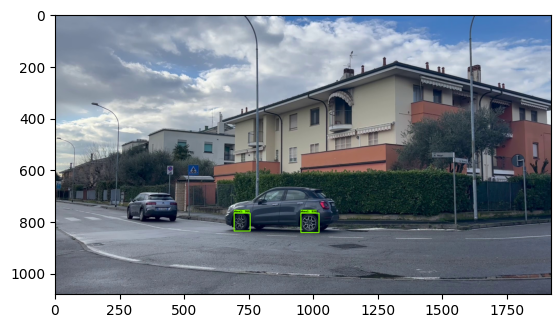

1


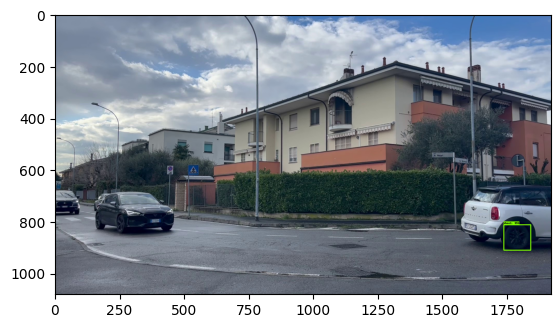

2


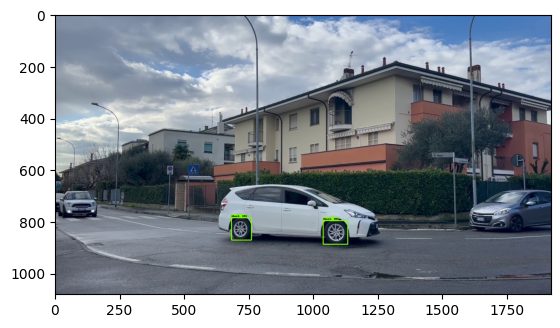

In [ ]:
test_images_np = []
for file_name in os.listdir("/content/drive/My Drive/IACV/test"):
  print(file_name)
  image_path = os.path.join(f"/content/drive/My Drive/IACV/test/{file_name}")
  img = load_image_into_numpy_array(image_path)
  #resized_image = cv2.resize(img, (img.s,640))
  test_images_np.append(np.expand_dims(img, axis=0))

@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  print(i)
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20))

  plt.show()

In [ ]:
idx = 6
print(detections['detection_boxes'][0][idx].numpy())

print(detections['detection_scores'][0].numpy())

[0.7285809  0.33183172 0.783837   0.36023954]
[0.8979501  0.6941605  0.28022775 0.2580099  0.16416982 0.12333675
 0.10819093 0.10516442 0.10345784 0.09357288 0.09099454 0.0780278
 0.07755377 0.07254971 0.06548198 0.06398338 0.05363443 0.05214448
 0.05114422 0.0501046  0.04819152 0.04480186 0.04012675 0.03965595
 0.03923384 0.03910527 0.03906086 0.03663517 0.0357044  0.03521111
 0.03406988 0.03398049 0.03351004 0.03232045 0.03066649 0.02980257
 0.0292896  0.02886395 0.02807666 0.02677896 0.02674065 0.02553536
 0.02512867 0.02442963 0.02421125 0.02391214 0.02352398 0.02289969
 0.02289694 0.02269044 0.02168697 0.02138183 0.02116087 0.01981203
 0.01978464 0.01953017 0.01938286 0.01865558 0.01852752 0.01806519
 0.01715838 0.01713766 0.01676731 0.01641248 0.01634418 0.01623739
 0.01601394 0.01601037 0.01595319 0.01575691 0.01571354 0.01552639
 0.01528624 0.01519639 0.01512541 0.0151035  0.01494839 0.01489545
 0.01481638 0.01476288 0.01474723 0.01473823 0.01459274 0.01450096
 0.01444819 0.014

In [ ]:
print(detections)